In [180]:
import os
import json
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.auto import tqdm

In [181]:
sns.set_style("ticks")
sns.set_context("paper")

In [182]:
MODES = ["textual", "visual"]

## Loading Results

In [183]:
# save_dir = "outputs/gcbc_eval/GCBC-CALVIN-s1"
save_dir = "../outputs/gcbc_eval/GCBC-CALVIN-s1"

In [184]:
result_keys = ["results", "evaluated_idxs", "videos", "videos_metadata"]
results_dict = {
    "textual": {k: None for k in result_keys},
    "visual": {k: None for k in result_keys},
}
results_dict["textual"]["save_dir"] = os.path.join(save_dir, "textual")
results_dict["visual"]["save_dir"] = os.path.join(save_dir, "visual")

In [185]:
for mode in MODES:#, 'visual']:
    for key in result_keys:
        if key != 'videos_metadata':
            file_path = os.path.join(results_dict[mode]['save_dir'], f'{key}.npz')
            results_dict[mode][key] = dict(**np.load(file_path))
        else:
            file_path = os.path.join(results_dict[mode]['save_dir'], f'{key}.json')
            with open(file_path, 'r') as f:
                results_dict[mode][key] = json.load(f)

In [186]:
tasks = list(results_dict['textual']['results'].keys())
n_tasks = len(tasks)

## Success Rate

In [187]:
for mode in MODES:
    results = results_dict[mode]['results']
    success_rates = {k: v.sum() / v.size for k, v in results.items()}
    total_sr = sum([v.sum() for v in results.values()]) / sum(
        [len(v) for v in results.values()]
    )
    results_dict[mode]['success_rates'] = success_rates
    results_dict[mode]['total_sr'] = total_sr

### Main

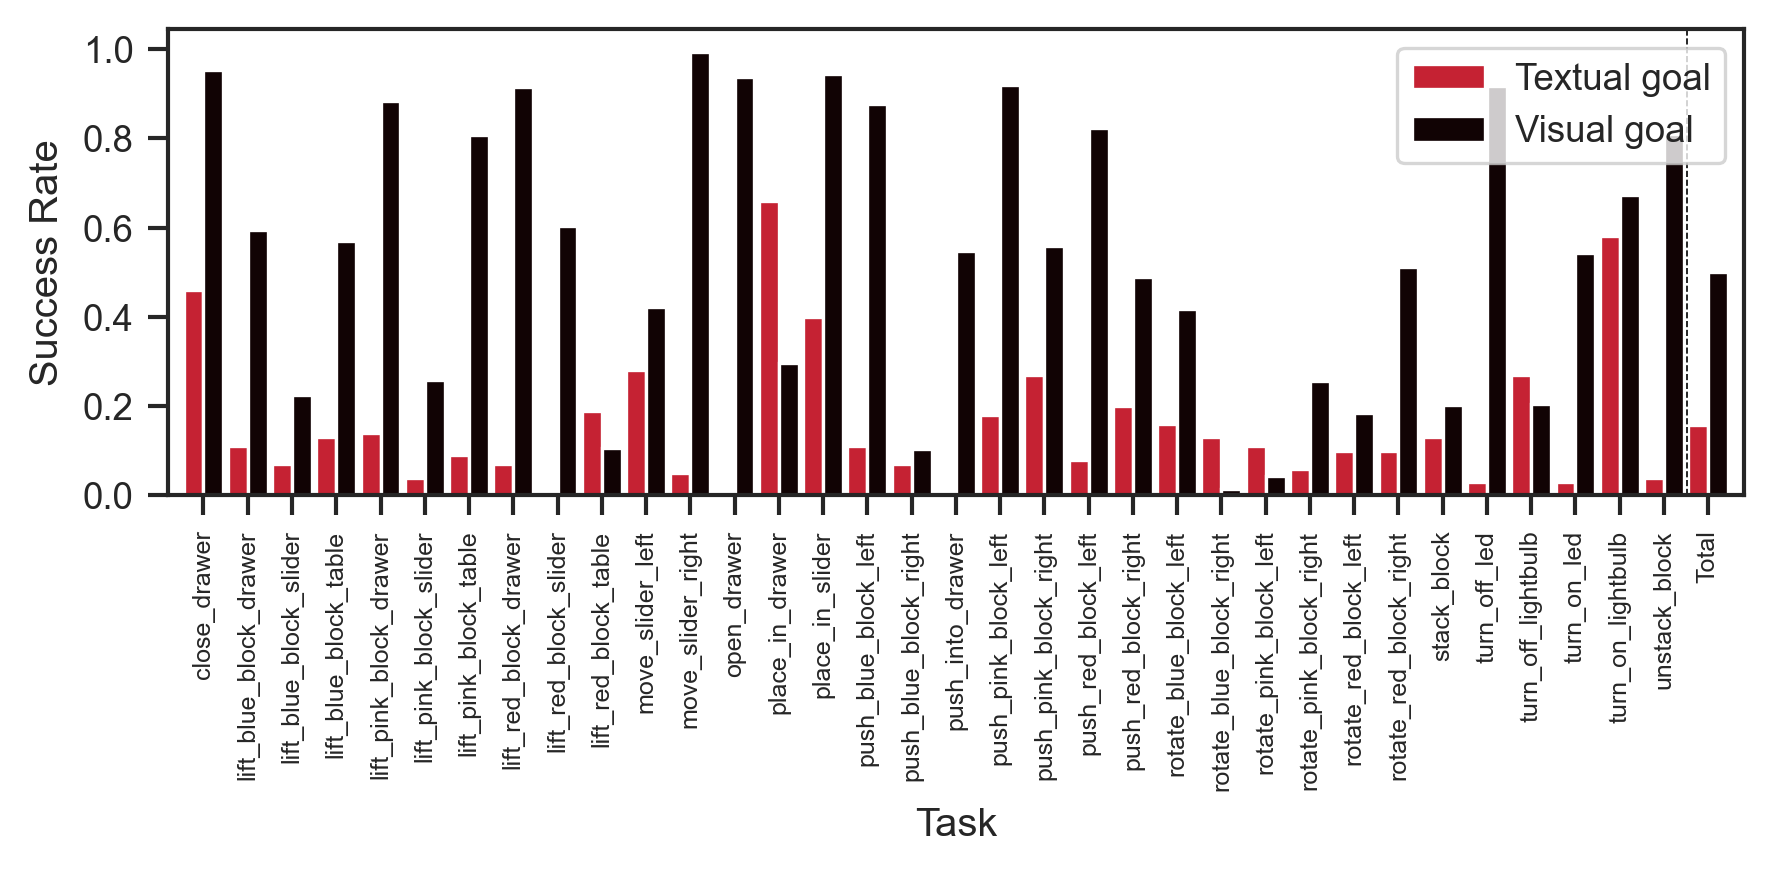

In [202]:
f, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=300)

# Position of bars on x-axis (+1 cuz we also plot the total SR
ind = np.arange(n_tasks + 1)
# Width of a bar
width = 0.45

textual_sr = [results_dict["textual"]["success_rates"][task] for task in tasks]
textual_total_sr = results_dict["textual"]["total_sr"]

visual_sr = [results_dict["visual"]["success_rates"][task] for task in tasks]
visual_total_sr = results_dict["textual"]["total_sr"]
# visual_sr = np.random.uniform(size=n_tasks)
# visual_total_sr = 0.5
# results_dict["visual"]["success_rates"] = {}
# for i, task in enumerate(tasks):
#     results_dict["visual"]["success_rates"][task] = visual_sr[i]
# results_dict["visual"]["total_sr"] = visual_total_sr
    
    
ax.bar(
    x=ind[:-1], height=textual_sr, width=width, color="#C52233", label="Textual goal"
)
ax.bar(
    x=ind[:-1] + width,
    height=visual_sr,
    width=width,
    color="#110304",
    label="Visual goal",
)

ax.bar(x=ind[-1], height=textual_total_sr, width=width, color='#C52233')
ax.bar(x=ind[-1] + width, height=visual_total_sr, width=width, color='#110304')

ax.axvline(x=len(tasks) - 0.25, color="black", linestyle="dashed", linewidth=0.4)

ax.set_xticks(ind + width / 2, tasks + ['Total'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=6)

ax.set_ylabel("Success Rate")
ax.set_xlabel("Task")

ax.margins(x=0.01)
ax.legend()

f.set_tight_layout(True)
plt.show()

In [67]:
sr_df = pd.DataFrame.from_records(
    [results_dict[mode]["success_rates"] for mode in MODES],
    index=["Textual Success Rate", "Visual Success Rate"],
)
sr_stats = sr_df.T.describe()
sr_df["Total"] = [textual_total_sr, visual_total_sr]

In [68]:
sr_df

,close_drawer,lift_blue_block_drawer,lift_blue_block_slider,lift_blue_block_table,lift_pink_block_drawer,lift_pink_block_slider,lift_pink_block_table,lift_red_block_drawer,lift_red_block_slider,lift_red_block_table,...,rotate_pink_block_right,rotate_red_block_left,rotate_red_block_right,stack_block,turn_off_led,turn_off_lightbulb,turn_on_led,turn_on_lightbulb,unstack_block,Total
Textual Success Rate,0.460000,0.110000,0.070000,0.130000,0.140000,0.040000,0.090000,0.070000,0.000000,0.190000,...,0.060000,0.1000,0.100000,0.130000,0.030000,0.270000,0.030000,0.580000,0.040000,0.157647
Visual Success Rate,0.704482,0.471213,0.183144,0.001975,0.624917,0.274763,0.182546,0.352008,0.767324,0.317366,...,0.018964,0.6248,0.769127,0.781067,0.010919,0.292417,0.685123,0.799528,0.317423,0.500000


In [70]:
sr_stats

,Textual Success Rate,Visual Success Rate
count,34.000000,34.000000
mean,0.157647,0.483234
std,0.158019,0.311893
min,0.000000,0.001975
25%,0.062500,0.185983
50%,0.110000,0.499100
75%,0.187500,0.759398
max,0.660000,0.967025


## Videos

In [78]:
from nlgoals.data.calvin.repo.code.datasets.calvin_data_module import CalvinDataModule
from nlgoals.interfaces.gcbc import calvin_gcbc_collate
from jsonargparse import Namespace
from omegaconf import OmegaConf
import hydra

In [79]:
data_dir = "/Users/thesofakillers/repos/thesis/data/calvin/task_D_D"
args = Namespace(
    **{
        "data": Namespace(
            **{
                "config_name": "default.yaml",
                "batch_size": 2,
                "shared_memory": False,
                "num_workers": 0,
                "data_dir": data_dir,
            }
        ),
    }
)

In [80]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize_config_module(
    config_module="nlgoals.data.calvin.repo.conf.datamodule"
)
datamodule_cfg = hydra.compose(
    config_name=args.data.config_name,
    overrides=[] if args.data.shared_memory is True else ["datasets=vision_lang"],
)
datamodule_cfg.batch_size = args.data.batch_size
datamodule_cfg.num_workers = args.data.num_workers
datamodule_cfg.root_data_dir = args.data.data_dir
datamodule = hydra.utils.instantiate(datamodule_cfg)
datamodule.collator.custom_collate_fn = calvin_gcbc_collate


In [81]:
datamodule.prepare_data()
datamodule.setup()

trying to load lang data from:  /Users/thesofakillers/repos/thesis/data/calvin/task_D_D/training/lang_annotations/auto_lang_ann.npy
trying to load lang data from:  /Users/thesofakillers/repos/thesis/data/calvin/task_D_D/validation/lang_annotations/auto_lang_ann.npy


In [82]:
dataset = datamodule.val_dataloader().dataset.datasets["lang"]

In [83]:
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [84]:
def prepare_video(video):
    # cut off empty frames
    frame_sums = np.sum(video, axis=(1, 2, 3))
    end_frame = np.where(frame_sums == 0)[0][0]
    video = video[:end_frame]
    # rescale pixels appropriately
    video = np.transpose(video, (0, 2, 3, 1)) / 2 + 0.5
    return video

In [175]:
def animate_video_visual(video, image_goal):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), dpi=300, frameon=False)

    goal_im = ax1.imshow(image_goal, aspect=1)
    ax1.axis("off")
    ax1.set_title("Visual goal")
    
    im = ax2.imshow(video[0, :, :, :], aspect=1)
    ax2.axis("off")
    ax2.set_title("Resulting Trajectory")

    plt.close()  # this is required to not display the generated image

    fig.subplots_adjust(
        left=0.01, bottom=0, right=0.99, top=0.99, wspace=None, hspace=None
    )

    animate_frame = partial(animate, im=im)

    anim = animation.FuncAnimation(fig, animate_frame, frames=video, interval=50)

    return anim


def animate_video_textual(video, lang):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300, frameon=False)

    im = ax.imshow(video[0, :, :, :], aspect="auto")
    ax.set_title(f'"{lang}"')
    ax.axis("off")

    plt.close()  # this is required to not display the generated image

    fig.subplots_adjust(left=0, bottom=0, right=1, top=0.94, wspace=None, hspace=None)

    animate_frame = partial(animate, im=im)

    anim = animation.FuncAnimation(fig, animate_frame, frames=video, interval=50)

    return anim

In [176]:
def save_animation(anim, output_path, writer):
    anim.save(
        output_path,
        writer=writer,
    )

In [177]:
def animate(frame, im):
    im.set_data(frame)
    return im

In [178]:
FFwriter = animation.FFMpegWriter(fps=20)
MODES = ['textual']
for mode in MODES:
    videos_dir = os.path.join(results_dict[mode]['save_dir'], "videos")
    os.makedirs(videos_dir, exist_ok=True)

    for task in tqdm(tasks[:1]):
        video = results_dict[mode]['videos'][task]
        episode_idx = results_dict[mode]['videos_metadata'][task]
        # we were never succesful in this task
        if episode_idx is None:
            continue
        episode = dataset[episode_idx]

        video = prepare_video(video)
        
        if mode == 'textual':
            goal = episode['lang']
            anim = animate_video_textual(video, goal)
        else:
            goal = episode['rgb_obs']['rgb_static'][-1].numpy()
            goal = np.transpose(goal, (1, 2, 0)) / 2 + 0.5
            anim = animate_video_visual(video, goal)

        save_path = os.path.join(videos_dir, f"{lang}.mp4")
        save_animation(anim, save_path, FFwriter)

  0%|          | 0/1 [00:00<?, ?it/s]